In [ ]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import deepstkit as dt
import torch

SEED = 0                     # Random seed for reproducibility
DATA_DIR = "/scratch/harsha.vasamsetti/DeepST/data/DLPFC"   # Directory containing spatial data
SAMPLE_ID = "151673"         # Sample identifier to analyze
RESULTS_DIR = "./Results"   # Directory to save outputs
N_DOMAINS = 7                # Expected number of spatial domains

/scratch/harsha.vasamsetti/DeepST


/scratch/harsha.vasamsetti/DeepST/deepstkit/utils_func.py:43: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path,
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial weights calculated. Average neighbors: 30.0
Gene expression weights calculated.
Final weight matrix calculated and stored in adata.obsm['weights_matrix_all']


Finding adjacent spots: 100%|██████████ [ time left: 00:00 ]


Step 1: Data augmentation completed
12.0000 neighbors per cell on average.
Step 2: Spatial graph computation completed
Running DeepST analysis...


Pretraining initial model: 100%|██████████ [ time left: 00:00 ]
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_re

Step 3: DeepST training completed
Memory usage: 5.05 GB
Total time: 0.61 minutes
Analysis completed successfully
Found resolution: 0.41 for 7 domains


/tmp/ipykernel_311645/2333838906.py:67: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


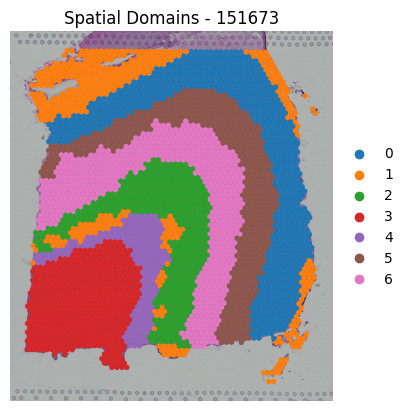

Analysis complete! Results saved to ./Results/151673_domains.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
print(os.getcwd())

# ========== Initialize Analysis ==========
# Set random seed and initialize DeepST
# dt.utils_func.seed_torch(seed=SEED)

# Create DeepST instance with analysis parameters
deepst = dt.main.run(
    save_path=RESULTS_DIR,
    task="Identify_Domain",  # Spatial domain identification
    pre_epochs=500,          # Pretraining iterations
    epochs=500,              # Main training iterations
    use_gpu=True             # Accelerate with GPU if available
)

# ========== Data Loading & Preprocessing ==========
# (Optional) Load spatial transcriptomics data (Visium platform)
# e.g. adata = anndata.read_h5ad("*.h5ad"), this data including .obsm['spatial']
adata = deepst._get_adata(
    platform="Visium",
    data_path=DATA_DIR,
    data_name=SAMPLE_ID
)

# Optional: Incorporate H&E image features (skip if not available)
# adata = deepst._get_image_crop(adata, data_name=SAMPLE_ID)

# ========== Feature Engineering ==========
# Data augmentation (skip morphological if no H&E)
adata = deepst._get_augment(
    adata,
    spatial_type="BallTree",
    use_morphological = False  # Set True if using H&E features
)

# Construct spatial neighborhood graph
graph_dict = deepst._get_graph(
    adata.obsm["spatial"],
    distType="KDTree"        # Spatial relationship modeling
)

# Dimensionality reduction
data = deepst._data_process(
    adata,
    pca_n_comps=200          # Reduce to 200 principal components
)

# ========== Model Training ==========
# Train DeepST model and obtain embeddings
deepst_embed, attention_data = deepst._fit(
    data=data,
    graph_dict=graph_dict,
    conv_type="GATConv"
)
adata.obsm["DeepST_embed"] = deepst_embed
adata.obsm["gat_attention"] = {'edge_index': attention_data[0], 'attention_scores': attention_data[1]}

# ========== Spatial Domain Detection ==========
# Cluster spots into spatial domains
adata = deepst._get_cluster_data(
    adata,
    n_domains=N_DOMAINS,     # Expected number of domains
    priori=True              # Use prior knowledge if available
)

# ========== Visualization & Output ==========
# Plot spatial domains
sc.pl.spatial(
    adata,
    color=["DeepST_refine_domain"],  # Color by domain
    frameon=False,
    spot_size=150,
    title=f"Spatial Domains - {SAMPLE_ID}"
)

# Save results
output_file = os.path.join(RESULTS_DIR, f"{SAMPLE_ID}_domains.pdf")
plt.savefig(output_file, bbox_inches="tight", dpi=300)
print(f"Analysis complete! Results saved to {output_file}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import torch

def visualize_gat_attention(
    adata,
    top_k=100,
    min_attention_threshold=0.1,
    figsize=(12, 10),
    spot_size=30,
    edge_alpha_scale=3.0,
    edge_width_scale=2.0,
    colormap='viridis',
    save_path=None
):
    """
    Visualize GAT attention weights on spatial transcriptomics data
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data with spatial coordinates and attention weights
    top_k : int
        Number of top attention edges to visualize (default: 100)
    min_attention_threshold : float
        Minimum attention score to display (default: 0.1)
    figsize : tuple
        Figure size (default: (12, 10))
    spot_size : int
        Size of spatial spots (default: 30)
    edge_alpha_scale : float
        Scale factor for edge transparency (default: 3.0)
    edge_width_scale : float
        Scale factor for edge width (default: 2.0)
    colormap : str
        Colormap for attention weights (default: 'viridis')
    save_path : str, optional
        Path to save the figure
    """
    
    # Check if attention data exists
    if 'gat_attention' not in adata.obsm:
        print("No GAT attention weights found. Make sure Conv_type='GATConv' in model.")
        return
    
    attention_data = adata.obsm['gat_attention']
    edge_index = attention_data['edge_index']
    attention_scores = attention_data['attention_scores']
    
    # Check if we have valid attention data
    if edge_index is None or attention_scores is None:
        print("Attention weights are None. This may happen with non-GAT convolutions.")
        return
    
    # Get spatial coordinates
    spatial_coords = adata.obsm['spatial']
    
    # Convert to numpy if needed
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.numpy()
    if isinstance(attention_scores, torch.Tensor):
        attention_scores = attention_scores.numpy()
    
    # Get the number of attention heads (if multi-head)
    if len(attention_scores.shape) > 1:
        # Average across attention heads
        attention_scores = attention_scores.mean(axis=1)
    
    # Filter edges by top-k and threshold
    attention_mask = attention_scores > min_attention_threshold
    if top_k is not None and top_k < len(attention_scores):
        # Get indices of top-k attention scores
        top_k_indices = np.argpartition(attention_scores, -top_k)[-top_k:]
        mask = np.zeros_like(attention_scores, dtype=bool)
        mask[top_k_indices] = True
        attention_mask = attention_mask & mask
    
    # Get filtered edges
    filtered_edges = edge_index[:, attention_mask]
    filtered_scores = attention_scores[attention_mask]
    
    if len(filtered_scores) == 0:
        print(f"No edges above threshold {min_attention_threshold}. Try lowering the threshold.")
        return
    
    # Normalize attention scores for visualization
    norm_scores = (filtered_scores - filtered_scores.min()) / (filtered_scores.max() - filtered_scores.min() + 1e-8)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Attention network on spatial coordinates
    ax1.set_title(f'GAT Attention Weights (Top {len(filtered_scores)} edges)', fontsize=14)
    ax1.set_aspect('equal')
    
    # Draw edges with attention weights
    segments = []
    for i in range(filtered_edges.shape[1]):
        source = filtered_edges[0, i]
        target = filtered_edges[1, i]
        segments.append([spatial_coords[source], spatial_coords[target]])
    
    # Create line collection with attention-based properties
    lc = LineCollection(
        segments,
        linewidths=norm_scores * edge_width_scale,
        alpha=norm_scores * edge_alpha_scale,
        cmap=colormap
    )
    lc.set_array(filtered_scores)
    ax1.add_collection(lc)
    
    # Plot spots
    ax1.scatter(
        spatial_coords[:, 0],
        spatial_coords[:, 1],
        c='lightgray',
        s=spot_size,
        edgecolors='black',
        linewidths=0.5,
        zorder=2
    )
    
    # Add colorbar
    cbar = plt.colorbar(lc, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Score', rotation=270, labelpad=15)
    
    ax1.set_xlabel('Spatial X')
    ax1.set_ylabel('Spatial Y')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Attention score distribution
    ax2.set_title('Attention Score Distribution', fontsize=14)
    ax2.hist(attention_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax2.axvline(min_attention_threshold, color='red', linestyle='--', label=f'Threshold: {min_attention_threshold}')
    ax2.set_xlabel('Attention Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add summary statistics
    textstr = f'Mean: {attention_scores.mean():.3f}\n'
    textstr += f'Std: {attention_scores.std():.3f}\n'
    textstr += f'Max: {attention_scores.max():.3f}\n'
    textstr += f'Min: {attention_scores.min():.3f}'
    ax2.text(0.65, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Attention visualization saved to {save_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n=== Attention Weight Summary ===")
    print(f"Total edges: {len(attention_scores)}")
    print(f"Displayed edges: {len(filtered_scores)}")
    print(f"Attention range: [{attention_scores.min():.4f}, {attention_scores.max():.4f}]")
    print(f"Mean attention: {attention_scores.mean():.4f} ± {attention_scores.std():.4f}")

# Visualize the attention weights
if 'gat_attention' in adata.obsm:
    visualize_gat_attention(
        adata,
        top_k=150,  # Show top 150 attention connections
        min_attention_threshold=0.05,  # Minimum attention score to display
        figsize=(16, 8),
        save_path=os.path.join(RESULTS_DIR, f"{SAMPLE_ID}_attention_weights.pdf")
    )
else:
    print("No attention weights found. Make sure to use Conv_type='GATConv' when training.")

In [ ]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import deepstkit as dt

SEED = 0  
DATA_DIR = "./data/DLPFC"        
SAMPLE_IDS = ['151673', '151674','151675', '151676']
RESULTS_DIR = "./Results"        
N_DOMAINS = 7                             
INTEGRATION_NAME = "_".join(SAMPLE_IDS)

# Set random seed and initialize DeepST
# dt.utils_func.seed_torch(seed=SEED)

integration_model = dt.main.run(
    save_path=RESULTS_DIR,
    task="Integration",       # Multi-sample integration task
    pre_epochs=500,           
    epochs=500,              
    use_gpu=True              
)

processed_data = []
spatial_graphs = []

for sample_id in SAMPLE_IDS:
    # Load and preprocess each sample
    adata = integration_model._get_adata(
        platform="Visium",
        data_path=DATA_DIR,
        data_name=sample_id
    )
    
    # Incorporate H&E image features (Optional)
    # adata = integration_model._get_image_crop(adata, data_name=sample_id)
    
    # Feature augmentation
    adata = integration_model._get_augment(
        adata,
        spatial_type="BallTree",
        use_morphological=False, # Use prior knowledge if available
    )
    
    # Construct spatial neighborhood graph
    graph = integration_model._get_graph(
        adata.obsm["spatial"],
        distType="KDTree"
    )
    
    processed_data.append(adata)
    spatial_graphs.append(graph)

# Combine multiple samples into integrated dataset
combined_adata, combined_graph = integration_model._get_multiple_adata(
    adata_list=processed_data,
    data_name_list=SAMPLE_IDS,
    graph_list=spatial_graphs
)

# Dimensionality reduction
integrated_data = integration_model._data_process(
    combined_adata,
    pca_n_comps=200
)

# Train with domain adversarial learning
embeddings = integration_model._fit(
    data=integrated_data,
    graph_dict=combined_graph,
    domains=combined_adata.obs["batch"].values,  # For batch correction
    n_domains=len(SAMPLE_IDS) )                 # Number of batches

combined_adata.obsm["DeepST_embed"] = embeddings

combined_adata = integration_model._get_cluster_data(
    combined_adata,
    n_domains=N_DOMAINS,
    priori=True,             # Use biological priors if available
    batch_key="batch_name",
)

# UMAP of integrated data
sc.pp.neighbors(combined_adata, use_rep='DeepST_embed')
sc.tl.umap(combined_adata)

# Save combined UMAP plot
umap_plot = sc.pl.umap(
    combined_adata,
    color=["DeepST_refine_domain", "batch_name"],
    title=f"Integrated UMAP - Samples {INTEGRATION_NAME}",
    return_fig=True
)
umap_plot.savefig(
    os.path.join(RESULTS_DIR, f"{INTEGRATION_NAME}_integrated_umap.pdf"),
    bbox_inches='tight',
    dpi=300
)

# Save individual spatial domain plots
for sample_id in SAMPLE_IDS:
    sample_data = combined_adata[combined_adata.obs["batch_name"]==sample_id]
    
    spatial_plot = sc.pl.spatial(
        sample_data,
        color='DeepST_refine_domain',
        title=f"Spatial Domains - {sample_id}",
        frameon=False,
        spot_size=150,
        return_fig=True
    )
    spatial_plot.savefig(
        os.path.join(RESULTS_DIR, f"{sample_id}_domains.pdf"),
        bbox_inches='tight',
        dpi=300
    )

print(f"Integration complete! Results saved to {RESULTS_DIR}")

/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/scratch/harsha.vasamsetti/sample_env/lib/python3.10/site-packages/anndata/utils.py:434: Futur

Spatial weights calculated. Average neighbors: 30.0
